# Kernel-based training of quantum models

Over the last few years, it has been increaing clear that mathematical foundations of quantum models are intimately related to kernel-method. In this tutorial, I will use 2 methods of QML, well known variational quantum circuit and alternative kernel based circuit, to train for classic iris datasets.

Prepare iris dataset.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor

import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
np.random.seed(1)

In [2]:
X, y = load_iris(return_X_y = True)
X = X[:100]
y = y[:100]

scaler = StandardScaler().fit(X)

X_scaled = scaler.transform(X)
y_scaled = 2 * (y - 0.5)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled)

In [3]:
n_qubits = len(X_train[0])

Now we have our dataset ready, let's try original variational circuit approach to train for the dataset.

### 1. Variational Circuit Model

In [4]:
dev_var = qml.device("default.qubit", wires = n_qubits)

In [5]:
@qml.qnode(dev_var, interface = "torch", diff_method="parameter-shift")
def quantum_model(x, params):
    AngleEmbedding(x, wires = range(n_qubits))
    StronglyEntanglingLayers(params, wires = range(n_qubits))
    return qml.expval(qml.PauliZ(0))

def quantum_model_plus_bias(x, params, bias):
    return quantum_model(x, params) + bias

def hinge_loss(predictions, targets):
    all_ones = torch.ones_like(targets)
    hinge_loss = all_ones - predictions * targets
    hinge_loss = relu(hinge_loss)
    return hinge_loss

In [6]:
def quantum_model_train(n_layers, steps, batch_size):
    params = np.random.random((n_layers, n_qubits, n_qubits - 1))
    params_torch = torch.tensor(params, requires_grad = True)
    bias_torch = torch.tensor(0.0)
    
    opt = torch.optim.Adam([params_torch, bias_torch], lr = 0.1)
    loss_history = []
    
    for i in range(steps):
        batch_ids = np.random.choice(len(X_train), batch_size)
        
        X_batch = X_train[batch_ids]
        y_batch = y_train[batch_ids]
        
        X_batch_torch = torch.tensor(X_batch, requires_grad = False)
        y_batch_torch = torch.tensor(y_batch, requires_grad = False)
        
        def closure():
            opt.zero_grad()
            preds = torch.stack(
            [quantum_model_plus_bias(x, params_torch, bias_torch) for x in X_batch_torch])
            loss = torch.mean(hinge_loss(preds, y_batch_torch))
            
            current_loss = loss.detach().numpy().item()
            loss_history.append(current_loss)
            
            if i % 10 == 0:
                print("steps", i, ", loss", current_loss)
            loss.backward()
            return loss
        
        opt.step(closure)
    return params_torch, bias_torch, loss_history

In [7]:
def quantum_model_predict(X_pred, trained_params, trained_bias):
    preds = []
    for x in X_test:
        pred_torch = quantum_model_plus_bias(x, trained_params, trained_bias)
        pred = pred_torch.detach().numpy().item()
        if pred > 0:
            pred = 1
        else:
            pred = -1
            
        preds.append(pred)
    return preds

Now we can train our strongly entangled quantum circuit.

In [8]:
n_layers = 2
batch_size = 20
steps = 100
trained_params, trained_bias, loss_history = quantum_model_train(n_layers, steps, batch_size)

pred_test = quantum_model_predict(X_test, trained_params, trained_bias)
print("accuracy on the test set: ", accuracy_score(pred_test, y_test))

steps 0 , loss 1.1413586273404828
steps 10 , loss 0.7847782655707439
steps 20 , loss 0.8228469937468239
steps 30 , loss 0.5551509120320679
steps 40 , loss 0.5348194363360191
steps 50 , loss 0.5459062454527552
steps 60 , loss 0.48425058460965237
steps 70 , loss 0.45853495858217974
steps 80 , loss 0.4973812292034907
steps 90 , loss 0.40900297780244876
accuracy on the test set:  1.0


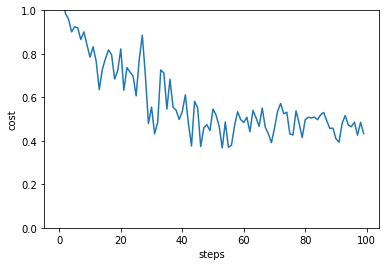

In [10]:
plt.plot(loss_history)
plt.ylim((0,1))
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()

The quantum circuit is successfully trained for the iris dataset. We can check the numbers of quantum function execution in the device,

In [11]:
n_exe = dev_var.num_executions
print(n_exe, " numbers of quantum functions were executed during training process.")

74025  numbers of quantum functions were executed during training process.


## 2. Kernel-based Training

In [15]:
dev_ker = qml.device("default.qubit", wires = n_qubits)

projector = np.zeros((2**n_qubits, 2**n_qubits))
projector[0, 0] = 1

In [18]:
@qml.qnode(dev_ker)
def kernel(x1, x2):
    AngleEmbedding(x1, wires = range(n_qubits))
    qml.inv(AngleEmbedding(x2, wires = range(n_qubits)))
    return qml.expval(qml.Hermitian(projector, wires = range(n_qubits)))

In [19]:
kernel(X_train[0], X_train[0])

tensor(1., requires_grad=True)

In [20]:
def kernel_matrix(A,B):
    return np.array([[kernel(a,b) for b in B] for a in A])

In [21]:
svm = SVC(kernel= kernel_matrix).fit(X_train, y_train)

In [22]:
predictions = svm.predict(X_test)
accuracy_score(predictions, y_test)

1.0

In [24]:
dev_ker.num_executions

7501